In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [2]:
tf.random.set_seed(0)

# Check the heuristics to select nosie variance

In [3]:
from src.ksd.kernel import median_heuristic, l2norm
from src.ksd.models import create_mixture_gaussian

In [4]:
dim = 5
n = 500

# Oracle choice of variance

In [5]:
ratio_target = 0.3
ratio_sample = 0.7

In [6]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)
target_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

2022-01-14 09:19:11.433661: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-14 09:19:12.022808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


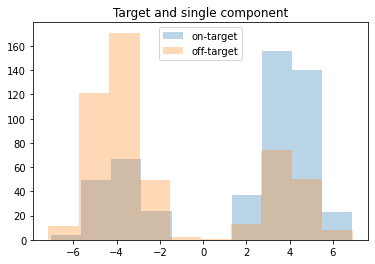

In [7]:
_ = plt.hist(samples_on.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component")

In [8]:
var = 5.
convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

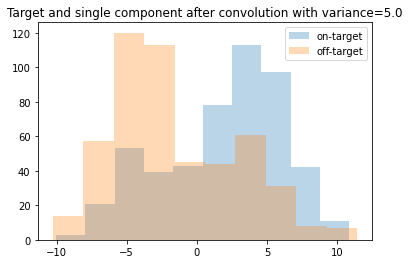

In [9]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title(f"Target and single component after convolution with variance={var}")

## Convolved KSD as a function of log std

In [10]:
from src.ksd.ksd import ConvolvedKSD
tf.random.set_seed(0)

In [11]:
ratio_target = 0.5
ratio_sample = 1.0

In [12]:
delta = 6.
dim = 5
n = 500
num_est = 10000

target, target_log_prob = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target, return_logprob=True)
proposal_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)
proposal_on = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)

convolution = tfd.MultivariateNormalDiag(0., tf.ones(dim))

kernel = IMQ(med_heuristic=True)

ksd = ConvolvedKSD(target=target, kernel=kernel, conv_kernel=None)

std_list = [tf.math.pow(2., x) for x in tf.experimental.numpy.arange(-10., 10., 1.0).numpy()]

In [13]:
# off-target sample
off_sample = proposal_off.sample(n)

# on-target sample
on_sample = proposal_on.sample(n)

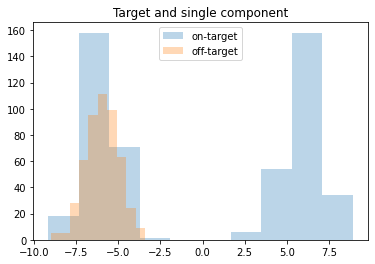

In [14]:
_ = plt.hist(on_sample.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(off_sample.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component")

In [15]:
ksd_df = pd.DataFrame(columns=["n", "ksd", "std", "seed", "type"])

for std in tqdm(std_list):
    for seed in range(10):
            # convolution sample
            conv_sample_full = convolution.sample(num_est) # for p

            conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
            conv_sample = tf.gather(conv_sample_full, conv_ind, axis=0) # for q

#             # off-target sample
#             off_sample = proposal_off.sample(n)

            log_noise_std = tf.math.log(std)

            ksd_val_off = ksd.eval(log_noise_std=log_noise_std, X=off_sample, Y=tf.identity(off_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_off, np.exp(log_noise_std), seed, "off-target"]

#             # on-target sample
#             on_sample = proposal_on.sample(n)

            log_noise_std_on = log_noise_std
            ksd_val_on = ksd.eval(log_noise_std=log_noise_std_on, X=on_sample, Y=tf.identity(on_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_on, np.exp(log_noise_std_on), seed, "target"]


  0%|          | 0/20 [00:00<?, ?it/s]

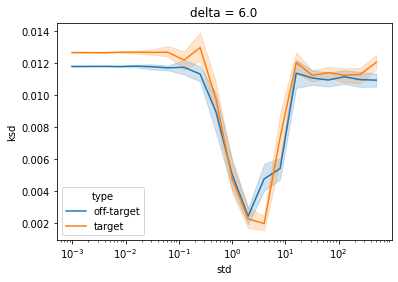

In [16]:
sns.lineplot(data=ksd_df, x="std", y="ksd", hue="type")
plt.xscale("log")
_ = plt.title(f"delta = {delta}")

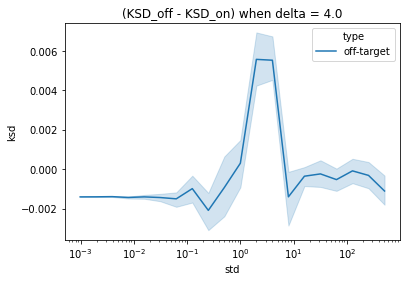

In [253]:
ksd_diff_df = ksd_df.loc[ksd_df.type == "off-target", ].copy()
ksd_diff_df["ksd"] = ksd_diff_df["ksd"].to_numpy() - ksd_df.loc[ksd_df.type == "target", "ksd"].to_numpy()

sns.lineplot(data=ksd_diff_df, x="std", y="ksd", hue="type")
plt.xscale("log")
_ = plt.title(f"(KSD_off - KSD_on) when delta = {delta}")

$\{v v^\intercal x: x \in \mathbb{R}^d \}$

$ \sigma Z, Z \sim N(0, I_d) $

$Z \sim N(0, 1)$, $\sigma v Z$

# MH approach

In [24]:
from src.ksd.langevin import RandomWalkMH
tf.random.set_seed(0)

In [25]:
ratio_target = 0.3
ratio_sample = 1.

In [26]:
delta = 4.
dim = 5
n = 500
num_est = 10000

target, target_log_prob = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target, return_logprob=True)
proposal_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)
proposal_on = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)

In [27]:
# off-target sample
off_sample = proposal_off.sample(n)

# on-target sample
on_sample = proposal_on.sample(n)

In [28]:
steps = 20
std = 10.
x_init_off = tf.identity(off_sample)

mh_off = RandomWalkMH(log_prob=target_log_prob)
mh_off.run(steps=steps, std=std, x_init=x_init_off, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.88it/s]


In [29]:
# check if the hard-coded log_prob equals to the built-in fn
diff = target_log_prob(x_init_off) - target.log_prob(x_init_off)
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [30]:
def plot_steps(plot_t_step, result):
    nplots = steps // plot_t_step
    nrows = int(np.sqrt(nplots))
    ncols = int(np.ceil(nplots / nrows))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

    ind = 0
    t = 0
    for row in ax:
        for col in row:
            if ind >= nplots: break

            col.hist(result.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
            col.hist(on_sample.numpy()[:, 0], bins=20, label="target", alpha=0.4)
            col.set_title(f"t = {t}")

            if t == 0:
                col.legend()

            ind += 1
            t += plot_t_step

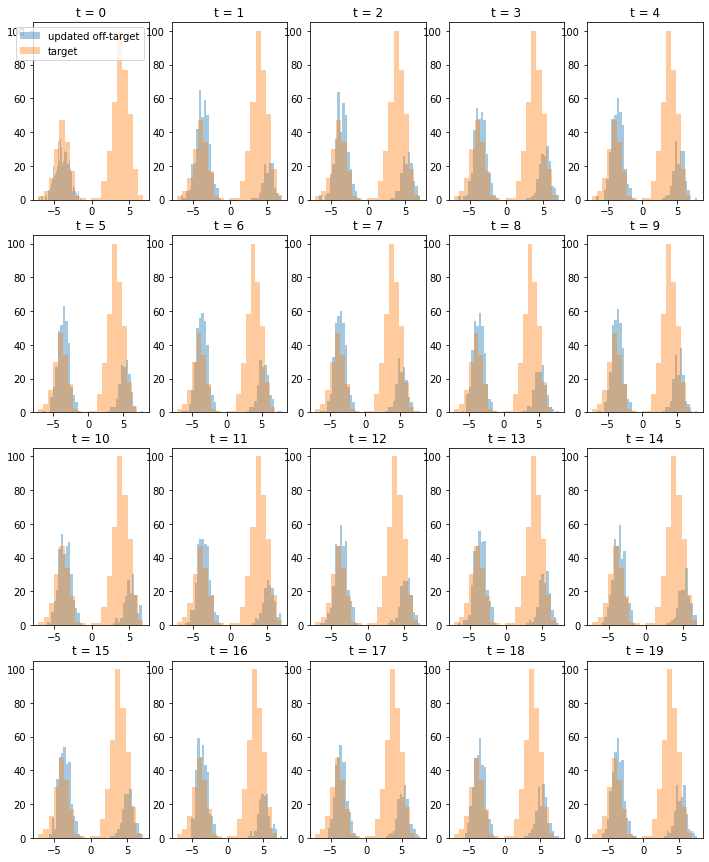

In [31]:
plot_t_step = 1 # plot every xxx steps
plot_steps(plot_t_step=plot_t_step, result=mh_off)

In [32]:
mh_on = RandomWalkMH(log_prob=target_log_prob)

x_init_on = tf.identity(on_sample)
mh_on.run(steps=steps, std=std, x_init=x_init_on)

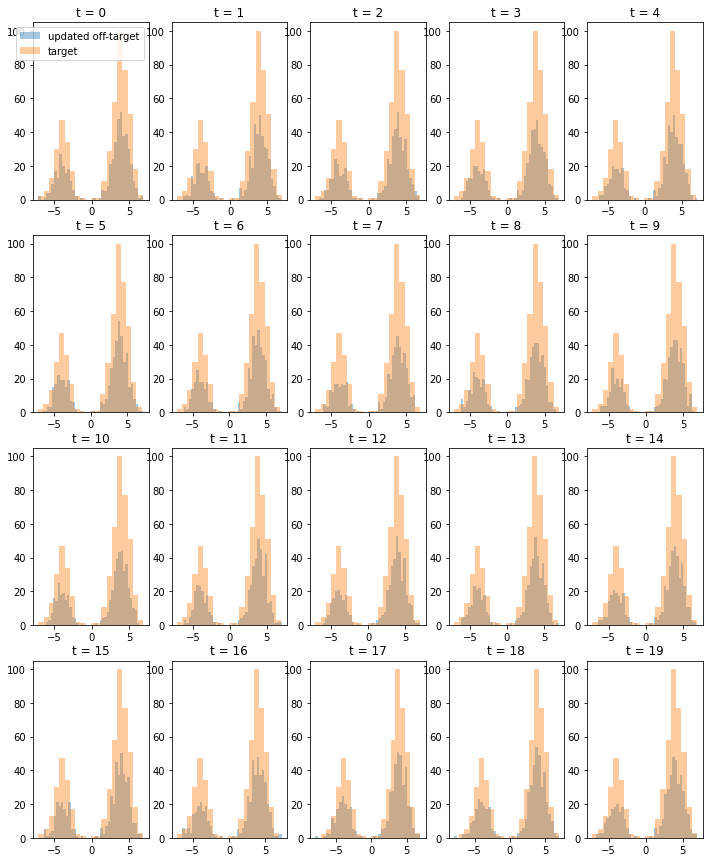

In [33]:
plot_steps(plot_t_step=plot_t_step, result=mh_on)

# KSD as a function of number of step

In [34]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 5

In [35]:
def run_mh_experiment(nrep, proposal_off, proposal_on, steps, std):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        mh_off = RandomWalkMH(log_prob=target_log_prob)
        mh_off.run(steps=steps, std=std, x_init=x_init_off)

        mh_on = RandomWalkMH(log_prob=target_log_prob)
        mh_on.run(steps=steps, std=std, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = mh_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = mh_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [36]:
nsteps=20
std=10.

ksd_df = run_mh_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=nsteps, 
    std=std)

  0%|          | 0/5 [00:00<?, ?it/s]

<AxesSubplot:xlabel='t', ylabel='ksd'>

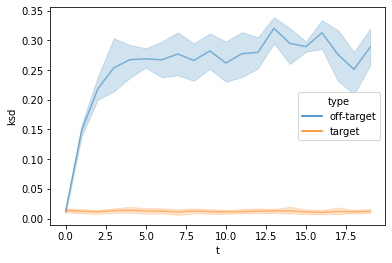

In [37]:
sns.lineplot(data=ksd_df, x="t", y="ksd", hue="type", alpha=0.5)

# Mixture of t and Banana distributions

In [300]:
import src.ksd.models as models

In [301]:
tf.random.set_seed(0)

In [302]:
dim = 2
nmodes = 10
ratio_target = [1/nmodes] * nmodes

random_weights = tfp.distributions.Uniform(low=0., high=1.).sample(nmodes)
indicator = tf.cast(tfp.distributions.Bernoulli(probs=0.5).sample(nmodes), dtype=bool)
random_weights = tf.where(indicator, random_weights, 0.0)
ratio_sample = random_weights / tf.reduce_sum(random_weights)

loc = tfp.distributions.Uniform(low=-tf.ones((dim,))*10, high=tf.ones((dim,))*20).sample(nmodes) # uniform in [-20, 20]^d


target, log_prob_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_target, loc=loc, b=0.03, return_logprob=True)
proposal_off, log_prob_off_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_sample, loc=loc, b=0.03, return_logprob=True)

In [303]:
n = 500
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

In [304]:
# loc = tf.cast(np.zeros((1,dim)), dtype=tf.float32)
# banana_dist, t_dist = models.create_banana(dim, loc)
banana_dist = models.create_banana(dim, loc[0, :])

In [305]:
def log_prob_fast(x, loc, sigma_inv, df=7):
    dim = x.shape[1]
    y = tf.matmul(x - loc, sigma_inv, transpose_b=True) # n x dim
    factor = -0.5 * (df + dim)
    log_prob = factor * tf.math.log(1 + tf.reduce_sum(y**2, axis=1) / df)
    return log_prob

def log_prob_banana_fast(x, loc, b):
    id_mat = tf.eye(dim)
    sigma_inv = tf.concat([id_mat[:, :1] * 1/10**2, id_mat[:, 1:]], axis=-1)
    y0 = x[:, 0:1]
    y = tf.Variable(x)
    y[:, 1:2].assign(x[..., 1:2] - b * y0**2 + 100 * b)
    return log_prob_fast(y, loc, sigma_inv)

def prob_fast(x, loc, sigma_inv, df=7):
    dim = x.shape[1]
    y = tf.matmul(x - loc, sigma_inv, transpose_b=True) # n x dim
    y_norm_sq = tf.einsum(
        "ij,ij->i",
        y,
        x - loc) # n
    factor = -0.5 * (df + dim)
    prob = (1 + y_norm_sq / df)**factor # n
    return prob

def banana_fast(x, loc, b, sigma_inv):
    y0 = x[:, 0:1]
    y = tf.Variable(x)
    y[:, 1:2].assign(x[..., 1:2] - b * y0**2 + 100 * b)
    return prob_fast(y, loc, sigma_inv)

def create_log_prob_mix_fast(dim, locs, b, ratio, scale):
    nmodes = len(ratio)
    id_mat = tf.eye(dim)
    scale_mat = tf.concat([id_mat[:, :1] * scale, id_mat[:, 1:]], axis=-1)
    sigma_inv = tf.linalg.inv(tf.matmul(scale_mat, scale_mat, transpose_b=True))
    
    cov_mat = tf.math.sqrt(0.01 * tf.math.sqrt(float(dim)) * tf.eye(dim))
    sigma_inv_t = tf.linalg.inv(tf.matmul(cov_mat, cov_mat, transpose_b=True))
    
    normalizer_ratio = tf.math.sqrt(
        tf.linalg.det(sigma_inv_t) / tf.linalg.det(sigma_inv))

    def log_prob_mix_fast(x):
        prob_banana_mix = 0.
        for i in range(5):
            prob_banana_mix += ratio[i] * banana_fast(x, locs[i, :], b, sigma_inv)

        prob_t_mix = 0.
        for i in range(nmodes-5):
            prob_t_mix += ratio[5+i] * prob_fast(x, locs[5+i], sigma_inv_t)

        log_prob = tf.math.log(prob_banana_mix + prob_t_mix * normalizer_ratio)
        return log_prob
    
    return log_prob_mix_fast

In [306]:
scale = 10.0
# loc = tf.cast(tf.zeros((1, dim)), dtype=tf.float32)

In [307]:
def create_fast_t(loc, scale=1.0):
    id_mat = tf.eye(dim)
    scale_mat = tf.concat([id_mat[:, :1] * scale, id_mat[:, 1:]], axis=-1)
    sigma_inv = tf.linalg.inv(tf.matmul(scale_mat, scale_mat, transpose_b=True))
    return lambda x: prob_fast(x, loc=loc, sigma_inv=sigma_inv)

def create_fast_banana(b, loc, scale=1.0):
    id_mat = tf.eye(dim)
    scale_mat = tf.concat([id_mat[:, :1] * scale, id_mat[:, 1:]], axis=-1)
    sigma_inv = tf.linalg.inv(tf.matmul(scale_mat, scale_mat, transpose_b=True))
    return lambda x: banana_fast(x, loc=loc, b=b, sigma_inv=sigma_inv)

t_prob_fast = create_fast_t(loc[0, :], scale=scale)
banana_prob_fast = create_fast_banana(b=0.03, loc=loc[0, :], scale=scale)
mix_log_prob_fast = create_log_prob_mix_fast(dim=dim, locs=loc, b=0.03, ratio=ratio_target, scale=scale)

In [308]:
# def create_t(loc, scale=1.0):
#     id_mat = tf.eye(dim)
#     scale_mat = tf.concat([id_mat[:, :1] * scale, id_mat[:, 1:]], axis=-1)
#     t_dist = tfd.MultivariateStudentTLinearOperator(
#         df=7, loc=loc, scale=tf.linalg.LinearOperatorLowerTriangular(scale_mat))
#     return t_dist

# t_dist = create_t(loc[0, :], scale)

In [309]:
# id_mat = tf.eye(dim)
# sigma_inv = tf.concat([id_mat[:, :1] * 1/10**2, id_mat[:, 1:]], axis=-1)
# sigma_inv = tf.concat([id_mat[:, :1] * 1., id_mat[:, 1:]], axis=-1)

# xx = tf.constant([[1., 0., 0., 0., 0.], [2., 0., 0., 0., 0.]])
xx = samples_off

In [311]:
# diff = (t_dist.log_prob(xx) - tf.math.log(t_prob_fast(xx)))

# diff = (banana_dist.log_prob(xx) - tf.math.log(banana_prob_fast(xx)))

# diff = log_prob_fn(xx) - mix_log_prob_fast(xx)

diff = log_prob_fn(xx) - target.log_prob(xx)

# print(diff)
print(tf.experimental.numpy.allclose(diff, diff[0]))

tf.Tensor(True, shape=(), dtype=bool)


(-20.0, 50.0)

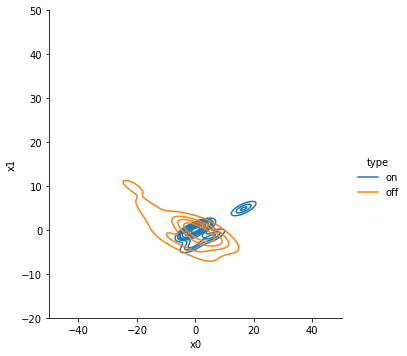

In [266]:
sns.displot(data=samples_df, x="x0", y="x1", kind="kde", hue="type")
# sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")
plt.xlim(-50, 50)
plt.ylim(-20, 50)

(-30.0, 30.0)

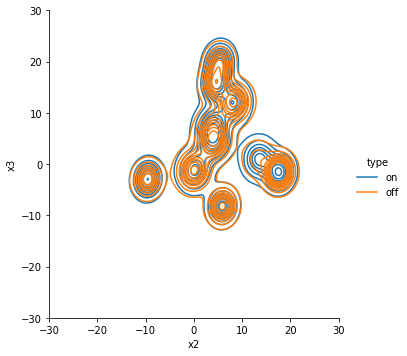

In [54]:
sns.displot(data=samples_df, x="x2", y="x3", kind="kde", hue="type")
# sns.scatterplot(data=samples_df, x="x2", y="x3")
plt.xlim(-30, 30)
plt.ylim(-30, 30)

# Mixture of 20 Gaussian

In [32]:
import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions
from src.ksd.langevin import RandomWalkMH
from src.ksd.ksd import KSD
from src.ksd.bootstrap import Bootstrap
from tqdm import tqdm
tf.random.set_seed(1)

In [33]:
dim = 5
nmodes = 5
means = tfp.distributions.Uniform(low=-tf.ones((dim,))*5, high=tf.ones((dim,))*5).sample(nmodes) # uniform in [-5, 5]^d
# means = tf.constant([[ 3.150137, 3.5368528, 3.494505, -2.2771752, -1.3727772 ],
#  [ 0.33028698, 1.8623676, 0.2722001, 4.1124535, -0.9760752 ],
#  [-4.0837107, -2.8521585, 2.1179333, -1.2412894, 4.7342815 ],
#  [ 2.1172857, 1.1514673, -3.1432784, -4.28977, -1.4204955 ]])

# indicator = tf.cast(tfp.distributions.Bernoulli(probs=0.5).sample(nmodes-1), dtype=bool)
# indicator = tf.concat([tf.constant([True]), indicator], axis=0)
random_weights = tfp.distributions.Uniform(low=0., high=1.).sample(nmodes)
# random_weights = tf.where(indicator, random_weights, 0.)
ratio_sample = random_weights / tf.reduce_sum(random_weights)
# ratio_sample = tf.constant([0.95802206, 0., 0., 0.04197793])

ratio_target = 0.5

target, log_prob_fn = models.create_mixture_20_gaussian(means, ratio=ratio_target, scale=0.1, return_logprob=True)
proposal_off, log_prob_fn_off = models.create_mixture_20_gaussian(means, ratio=ratio_sample, scale=0.1, return_logprob=True)

In [34]:
n = 500
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

<AxesSubplot:xlabel='x0', ylabel='x1'>

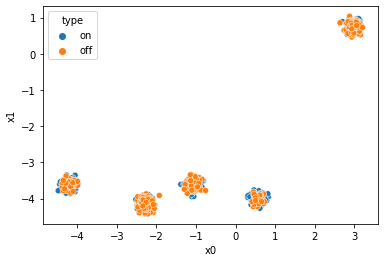

In [35]:
# sns.displot(data=samples_df, x="x0", y="x1", kind="kde", hue="type")
sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")

In [36]:
# find modes
nstart_pts = 200 * dim
mode_threshold = 0.01

unif_dist = tfp.distributions.Uniform(low=-tf.ones((dim,)), high=tf.ones((dim,)))
start_pts = 5. * unif_dist.sample(nstart_pts)

In [37]:
start_pts = samples_off
mode_list, _ = find_modes(start_pts, log_prob_fn, threshold=mode_threshold, max_iterations=50, parallel_iterations=1,)
print("num of modes found:", len(mode_list))

num of modes found: 5


In [38]:
# tf.experimental.numpy.allclose(start_pts, tf.concat([tf.reshape(x, (1, -1)) for x in mode_list], axis=0))

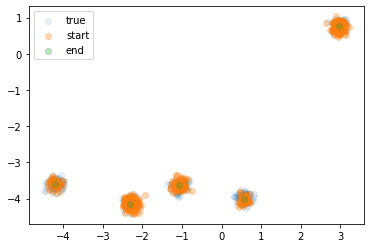

In [24]:
end_pts = tf.concat([tf.reshape(x, (1, -1)) for x in mode_list], axis=0).numpy()
plt.scatter(samples_on_df.x0, samples_on_df.x1, label="true", alpha=0.1)
plt.scatter(start_pts[:, 0], start_pts[:, 1], label="start", alpha=0.3)
plt.scatter(end_pts[:, 0], end_pts[:, 1], label="end", alpha=.3)
plt.legend()

In [25]:
dir_vec_list, dir_ind_list = pairwise_directions(mode_list, return_index=True)

In [26]:
sample_init = samples_off
ntrain = n // 2
std_ls = np.linspace(0.5, 1.5, 26).tolist()
T = 50

sample_init_train, sample_init_test = sample_init[:ntrain, ], sample_init[ntrain:, ]

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)

In [27]:
# find v_{i^*, j^*}, \sigma^*_{i^*, j^*}
best_ksd = 0.
best_ind = 0
if len(mode_list) == 1:
    dir_vec_list = [mode_list[0]]
else:
    dir_vec_list = pairwise_directions(mode_list)

for j, dir_vec in tqdm(enumerate(dir_vec_list)):
    # loop through directional vecs

    for i, std in enumerate(std_ls):
        # loop through jump scales
        
        # run dynamic for T steps
        mh = RandomWalkMH(log_prob=log_prob_fn)
        mh.run(steps=T, std=std, x_init=sample_init_train, dir_vec=dir_vec)

        # compute ksd
        x_t = mh.x[-1, :, :].numpy()
        ksd_val = ksd(x_t, tf.identity(x_t)).numpy()

        # update if ksd is larger
        if ksd_val > best_ksd:
            best_std = std
            best_dir_vec = dir_vec
            best_ksd = ksd_val
            best_ind = j

10it [01:35,  9.59s/it]


In [28]:
print(best_std, best_dir_vec)

# run dynamic for T steps with test data and optimal params
mh = RandomWalkMH(log_prob=log_prob_fn)
mh.run(steps=T, x_init=sample_init_test, std=best_std, dir_vec=best_dir_vec)

# get perturbed samples
x_t = mh.x[-1, :, :].numpy()

1.02 tf.Tensor([-2.8745577  -0.13422155 -1.3070726  -3.0589972  -9.1134205 ], shape=(5,), dtype=float32)


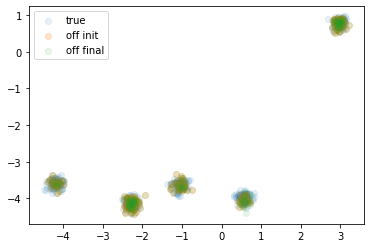

In [29]:
# samples_off_pert = pd.DataFrame({"x0": x_t[:, 0], "x1": x_t[:, 1], "type": "off pert"})
# samples_off_pert = pd.concat([samples_off_pert, samples_off_df], ignore_index=True)

plt.scatter(samples_on_df.x0, samples_on_df.x1, label="true", alpha=0.1)
plt.scatter(mh.x[0, :, 0], mh.x[0, :, 1], label="off init", alpha=0.2)
plt.scatter(mh.x[-1, :, 0], mh.x[-1, :, 1], label="off final", alpha=0.1)
plt.legend()

In [30]:
# bootstrap test
alpha = 0.05
nrep = 100
num_boot = 1000
bootstrap = Bootstrap(ksd, n-ntrain)
multinom_samples = bootstrap.multinom.sample((nrep, num_boot)) # nrep x num_boot x ntest

2022-02-08 16:06:14.789295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [31]:
# get multinomial sample
multinom_one_sample = multinom_samples[0, :] # nrep x num_boost x ntest

# compute p-value
_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print(p_val)

0.049
